In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json,argparse
import numpy as np
import pandas as pd
# plot the data
import matplotlib.pyplot as plt
import natsort

In [2]:
def get_e2e_times(dir_path: str) -> list:
    import os
    e2e_times = {}
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if "lotustrace_log" in file:
                # custom_log_b128_gpu1
                key = file.replace("lotustrace_log_","").replace(".csv","")
                # key = file.split('_')[-2] + "_" + file.split('_')[-1]
                # file is a csv
                df = pd.read_csv(os.path.join(root, file))
                try:
                    e2e_times[key] = df['wall(s)'].abs().sum()
                except:
                    e2e_times[key] = 0
    return e2e_times

In [5]:
dir_1 = "../final_analysis_cloudlab_twenty/e2e"
dir_4 = "../final_analysis_cloudlab_good_alloc_twenty/e2e"
# dir_2 = "../lotustrace_result_priority/e2e"
dir_2 = "../final_analysis_cloudlab_io_badalloc_twenty/e2e"
dir_3 = "../final_analysis_cloudlab_io_twenty/e2e"

e2e_times_1 = get_e2e_times(dir_1)
e2e_times_2 = get_e2e_times(dir_2)
e2e_times_3 = get_e2e_times(dir_3)
e2e_times_4 = get_e2e_times(dir_4)

e2e_times_1 = dict(sorted(e2e_times_1.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
e2e_times_2 = dict(sorted(e2e_times_2.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
e2e_times_3 = dict(sorted(e2e_times_3.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
e2e_times_4 = dict(sorted(e2e_times_4.items(), key=lambda x: natsort.natsort_key(x[0].lower())))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Calculate percentage differences
percentage_differences = {key: (e2e_times_2[key] - e2e_times_1[key]) / e2e_times_1[key] * 100 for key in e2e_times_2}

# Group data by number of GPUs
gpu_groups = {}
for key, value in percentage_differences.items():
    match = re.match(r'b(\d+)_gpu(\d+)_w(\d+)', key.split('.')[0])
    if match:
        batch_size, gpus, workers = match.groups()
        if gpus not in gpu_groups:
            gpu_groups[gpus] = {}
        gpu_groups[gpus][f'b{batch_size}_w{workers}'] = value

# Set up the plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

# Create a plot for each GPU group
for gpus, data in gpu_groups.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    keys = list(data.keys())
    values = list(data.values())
    
    # Create the bars
    bars = ax.bar(keys, values, width=0.6)
    
    # Customize the plot
    ax.set_ylabel('Percentage Difference (%)', fontsize=12)
    ax.set_title(f'Percentage Difference in E2E Times for {gpus} GPUs\n(Optimised vs Optimised (No Pin))', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
    
    # Color the bars based on positive (blue) or negative (red) values
    for bar, value in zip(bars, values):
        bar.set_color(sns.color_palette("deep")[0] if value >= 0 else sns.color_palette("deep")[3])
    
    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

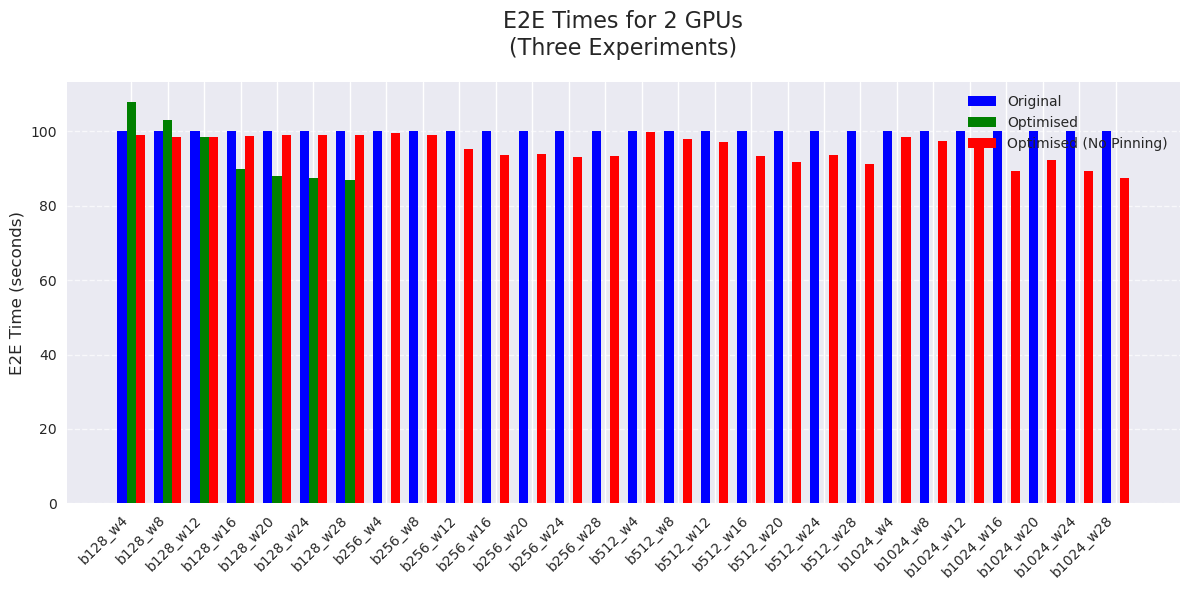

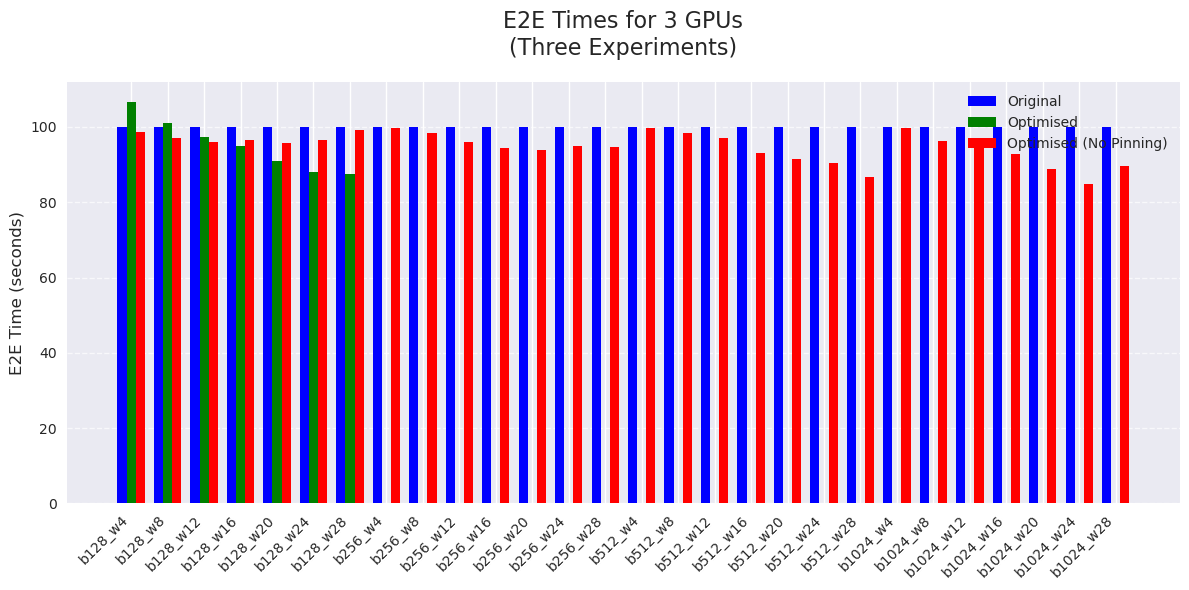

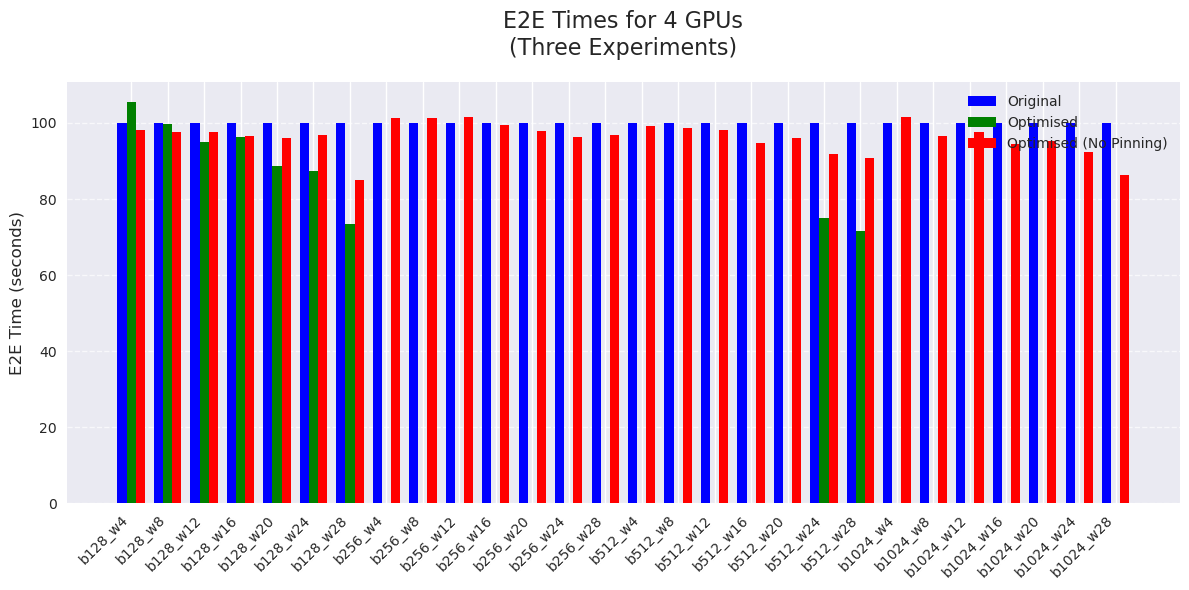

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from natsort import natsorted

# Group data by number of GPUs
gpu_groups = {}
for key in e2e_times_3.keys():
    match = re.match(r'b(\d+)_gpu(\d+)_w(\d+)', key.split('.')[0])
    if match:
        batch_size, gpus, workers = match.groups()
        if gpus not in gpu_groups:
            gpu_groups[gpus] = {}
        gpu_groups[gpus][f'b{batch_size}_w{workers}'] = {
            'Original': e2e_times_1[key]/e2e_times_1[key] * 100,
            'Optimised': e2e_times_2[key]/(e2e_times_1[key]) * 100,
            'Optimised (No Pinning)': e2e_times_3[key]/e2e_times_1[key] * 100
        }

# Set up the plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

# Create a plot for each GPU group
for gpus, data in gpu_groups.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort keys naturally and prepare data for plotting
    sorted_keys = natsorted(data.keys())
    x_labels = sorted_keys
    experiment_1_values = [data[key]['Original'] for key in sorted_keys]
    experiment_2_values = [data[key]['Optimised'] for key in sorted_keys]
    experiment_3_values = [data[key]['Optimised (No Pinning)'] for key in sorted_keys]
    
    # Define bar positions
    x = range(len(sorted_keys))
    bar_width = 0.25
    
    # Plot bars for each experiment
    ax.bar([pos - bar_width for pos in x], experiment_1_values, width=bar_width, label='Original', color='blue')
    ax.bar(x, experiment_2_values, width=bar_width, label='Optimised', color='green')
    ax.bar([pos + bar_width for pos in x], experiment_3_values, width=bar_width, label='Optimised (No Pinning)', color='red')
    
    # Customize the plot
    ax.set_ylabel('E2E Time (seconds)', fontsize=12)
    ax.set_title(f'E2E Times for {gpus} GPUs\n(Three Experiments)', fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10)
    
    # Add grid lines and remove unnecessary spines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()


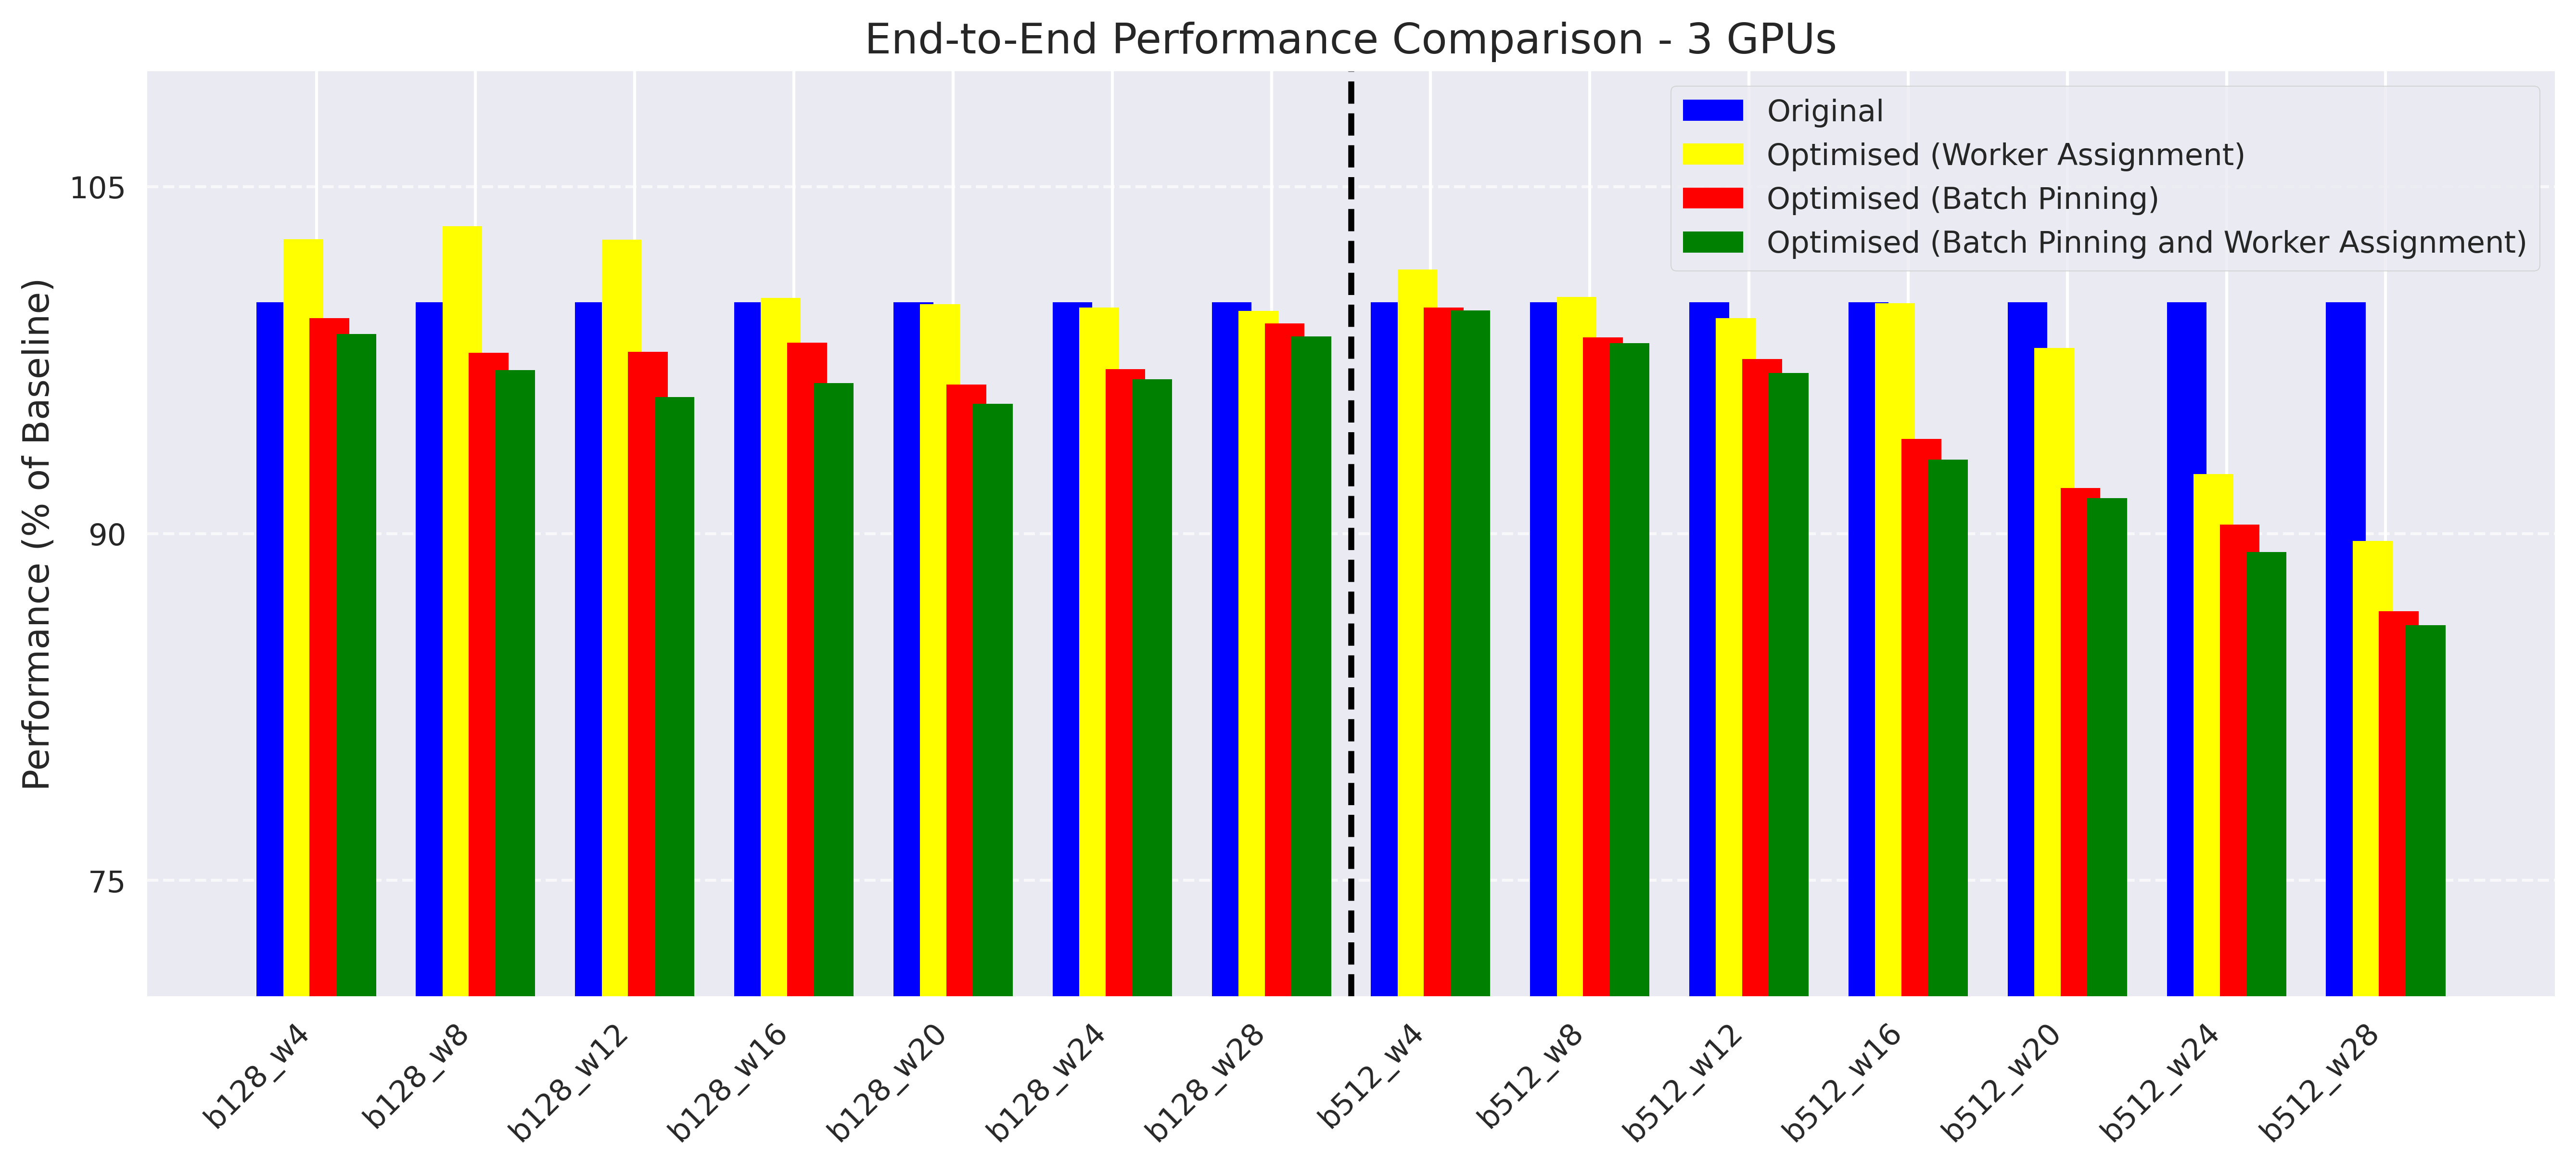

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from natsort import natsorted

# ======================
# DATA PROCESSING
# ======================
def group_data_by_gpus(results_dict):
    """Organize experiment results into GPU-based groups with normalized values"""
    gpu_groups = {}
    
    
    for key in results_dict.keys():
        # Extract configuration parameters
        config_match = re.match(r'b(\d+)_gpu(\d+)_w(\d+)', key.split('.')[0])
        if not config_match:
            continue
            
        batch_size, gpus, workers = config_match.groups()
        # if(int(workers) <= 4):
        #     continue
        if(int(batch_size) == 256 or int(batch_size) == 1024):
            continue
        base_time = e2e_times_1[key]  # Original experiment time
        
        # Initialize GPU group if needed
        gpu_groups.setdefault(gpus, {})
        (e2e_times_4[key] / base_time) * 100
        # Store normalized values
        config_key = f'b{batch_size}_w{workers}'
        gpu_groups[gpus][config_key] = {
            'Original': (e2e_times_1[key] / base_time) * 100,
            'Optimised (Worker Assignment)': ((e2e_times_4[key] / base_time) * 100),
            'Optimised (Batch Pinning)': ((e2e_times_2[key]) / base_time) * 100,
            'Optimised (Batch Pinning and Worker Assignment)': ((e2e_times_3[key]) / base_time) * 100
        }
    # print(gpu_groups)
    return gpu_groups

def group_data_by_batch_sizes(results_dict):
    """Organize experiment results into batch size-based groups with normalized values"""
    batch_groups = {}
    
    for key in results_dict.keys():
        # Extract configuration parameters
        config_match = re.match(r'b(\d+)_gpu(\d+)_w(\d+)', key.split('.')[0])
        if not config_match:
            continue
            
        batch_size, gpus, workers = config_match.groups()
        # if(int(workers) <= 4):
        #     continue
        # if(int(batch_size) == 128):
        #     continue
        base_time = e2e_times_1[key]  # Original experiment time
        
        # Initialize batch group if needed
        batch_groups.setdefault(batch_size, {})
        
        # Store normalized values
        config_key = f'g{gpus}_w{workers}'
        batch_groups[batch_size][config_key] = {
            'Original': (e2e_times_1[key] / base_time) * 100,
            'Optimised': (e2e_times_2[key] / base_time) * 100,
            'Optimised (No Pinning)': (e2e_times_3[key] / base_time) * 100
        }
    return batch_groups

def group_data_by_workers(results_dict):
    """Organize experiment results into worker-based groups with normalized values"""
    worker_groups = {}
    
    for key in results_dict.keys():
        # Extract configuration parameters
        config_match = re.match(r'b(\d+)_gpu(\d+)_w(\d+)', key.split('.')[0])
        if not config_match:
            continue
            
        batch_size, gpus, workers = config_match.groups()
        # if(int(workers) <= 4):
        #     continue
        # if(int(batch_size) == 128):
        #     continue
        base_time = e2e_times_1[key]  # Original experiment time
        
        # Initialize worker group if needed
        worker_groups.setdefault(workers, {})
        
        # Store normalized values
        config_key = f'b{batch_size}_g{gpus}'
        worker_groups[workers][config_key] = {
            'Original': (e2e_times_1[key] / base_time) * 100,
            'Optimised': (e2e_times_2[key] / base_time) * 100,
            'Optimised (No Pinning)': (e2e_times_3[key] / base_time) * 100
        }
    return worker_groups

# ======================
# VISUALIZATION SETUP
# ======================
def configure_plot_style():
    """Set consistent styling for all plots"""
    plt.style.use('seaborn-v0_8')
    sns.set_palette("deep")
    plt.rcParams['figure.dpi'] = 450
    plt.rcParams['font.size'] = 10

# ======================
# PLOTTING FUNCTION
# ======================
def create_grouped_barplot(gpu_count, group_data):
    """Create a grouped bar plot for specific GPU configuration"""
    fig, ax = plt.subplots(figsize=(12, 5.5))
    sorted_keys = natsorted(group_data.keys())
    
    # Experiment configuration
    experiments = [
        {'label': 'Original', 'color': 'blue', 'offset': -1},
        {'label': 'Optimised (Worker Assignment)', 'color': 'yellow', 'offset': -0.33},
        {'label': 'Optimised (Batch Pinning)', 'color': 'red', 'offset': 0.33},
        {'label': 'Optimised (Batch Pinning and Worker Assignment)', 'color': 'green', 'offset': 1}
    ]
    
    # Plot configuration
    bar_width = 0.25
    x_positions = range(len(sorted_keys))
    
    for exp in experiments:
        values = [group_data[key][exp['label']] for key in sorted_keys]
        offsets = [pos + (exp['offset'] * bar_width) for pos in x_positions]
        ax.bar(offsets, values, width=bar_width, 
               label=exp['label'], color=exp['color'])
    
    # Axis formatting
    ax.set_ylabel('Performance (% of Baseline)', fontsize=12)
    ax.set_title(f'End-to-End Performance Comparison - {gpu_count} GPUs', fontsize=14)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sorted_keys, rotation=45, ha='right')
    
    # Reduce number of y-axis ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    ax.set_ylim(70, 110)

    # Styling elements
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    transition_index = next((i for i, k in enumerate(sorted_keys) if 'b512' in k), None)
    ax.axvline(x=transition_index-0.5, color='black', linestyle='--', linewidth=2)
    ax.legend(frameon=True, loc='upper right')
    fig.tight_layout()
    return fig

# ======================
# MAIN EXECUTION
# ======================
if __name__ == "__main__":
    configure_plot_style()
    gpu_groups = group_data_by_gpus(e2e_times_3)
    
    for gpu_count, group_data in gpu_groups.items():
        if int(gpu_count) != 3:
            continue
        fig = create_grouped_barplot(gpu_count, group_data)
        plt.show()
    
    # batch_groups = group_data_by_batch_sizes(e2e_times_3)
    # for batch_size, group_data in batch_groups.items():
    #     fig = create_grouped_barplot(f'Batch Size {batch_size}', group_data)
    #     plt.show()
    
    # worker_groups = group_data_by_workers(e2e_times_3)
    # for worker_count, group_data in worker_groups.items():
    #     fig = create_grouped_barplot(f'{worker_count} Workers', group_data)
    #     plt.show()
